**Source Data: Meta Trader 5**<br>
**5 Minute EURJPY Pair**

# Import Library


In [56]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
%cd /content/drive/MyDrive/LTSM MODEL

/content/drive/MyDrive/LTSM MODEL


In [58]:
!pip install darts

In [59]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

#warning
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("darts").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")


# Preprocess Data

In [60]:
df_raw = pd.read_csv('EURJPY5.csv')
df_raw = df_raw.rename(columns={'<DATE>':'Date', '<CLOSE>':'Close', '<TIME>':'Time', '<TICKVOL>':'Tickvol'})
df_raw['Datetime'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'])
df_raw = df_raw.set_index('Datetime')
df_raw = df_raw.drop(columns=['Date', 'Time'])
df_raw = df_raw.tail(2000)
df_raw

,<OPEN>,<HIGH>,<LOW>,Close,Tickvol,<VOL>,<SPREAD>
Datetime,,,,,,,
2025-05-15 23:45:00,162.873,162.914,162.860,162.910,210,0,20
2025-05-15 23:50:00,162.909,162.923,162.905,162.919,165,0,20
2025-05-15 23:55:00,162.914,162.964,162.870,162.936,339,0,23
2025-05-16 00:00:00,162.938,162.938,162.840,162.871,21,0,53
2025-05-16 00:05:00,162.872,162.919,162.872,162.888,49,0,129
...,...,...,...,...,...,...,...
2025-05-26 23:35:00,162.576,162.589,162.575,162.587,35,0,20
2025-05-26 23:40:00,162.586,162.587,162.577,162.579,49,0,20
2025-05-26 23:45:00,162.588,162.622,162.588,162.615,110,0,20


In [61]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2025-05-15 23:45:00 to 2025-05-26 23:55:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <OPEN>    2000 non-null   float64
 1   <HIGH>    2000 non-null   float64
 2   <LOW>     2000 non-null   float64
 3   Close     2000 non-null   float64
 4   Tickvol   2000 non-null   int64  
 5   <VOL>     2000 non-null   int64  
 6   <SPREAD>  2000 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 125.0 KB


<Axes: xlabel='Datetime'>

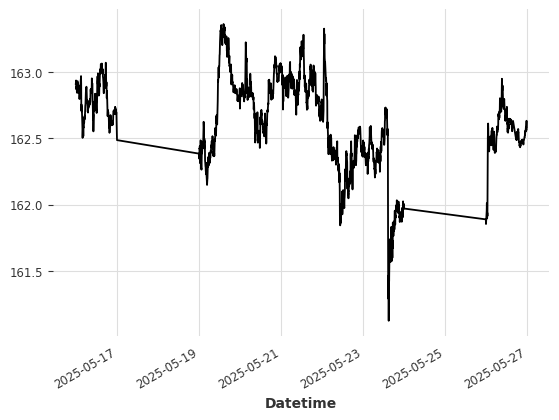

In [62]:
df_raw.Close.plot()

<Axes: xlabel='Datetime'>

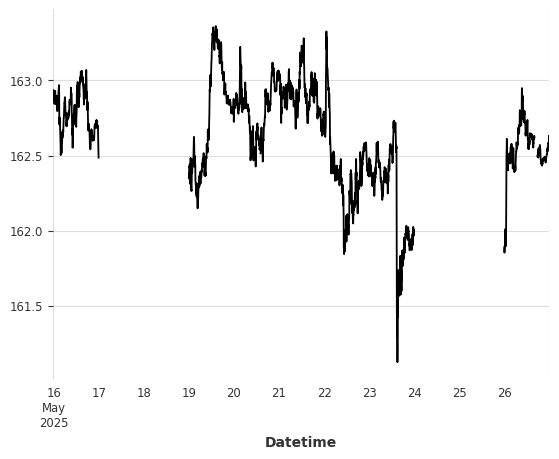

In [63]:
df_raw = df_raw.asfreq('5min')
df_raw.Close.plot()

In [64]:
df_raw.isnull().sum()

,0
<OPEN>,1171
<HIGH>,1171
<LOW>,1171
Close,1171
Tickvol,1171
<VOL>,1171
<SPREAD>,1171


<Axes: xlabel='Datetime'>

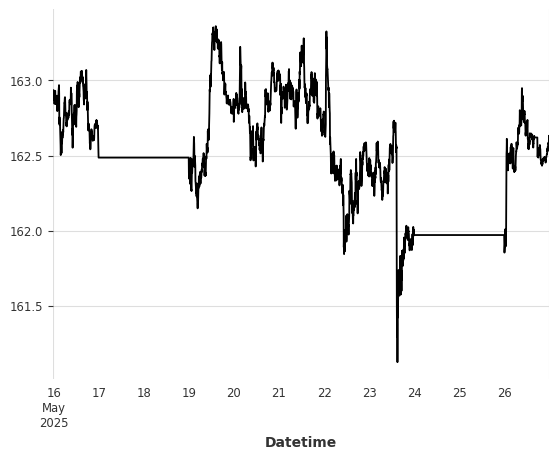

In [65]:
df = df_raw.ffill()
df.Close.plot()

In [66]:
df.isnull().sum()

,0
<OPEN>,0
<HIGH>,0
<LOW>,0
Close,0
Tickvol,0
<VOL>,0
<SPREAD>,0


# Explanatory Data Analysis

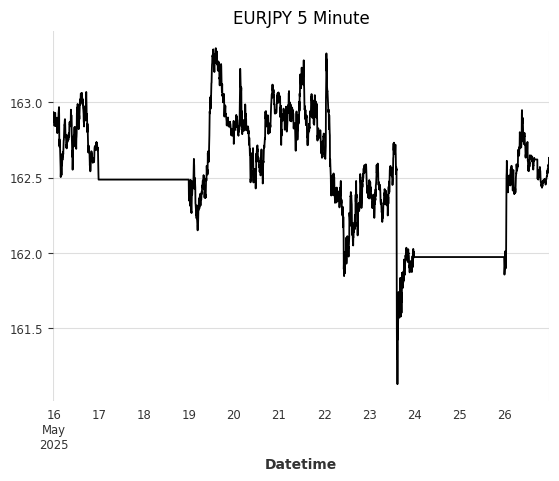

In [67]:
# Plot the daily demand
df['Close'].plot(title = 'EURJPY 5 Minute')
plt.show()

(162.0, 163.5)

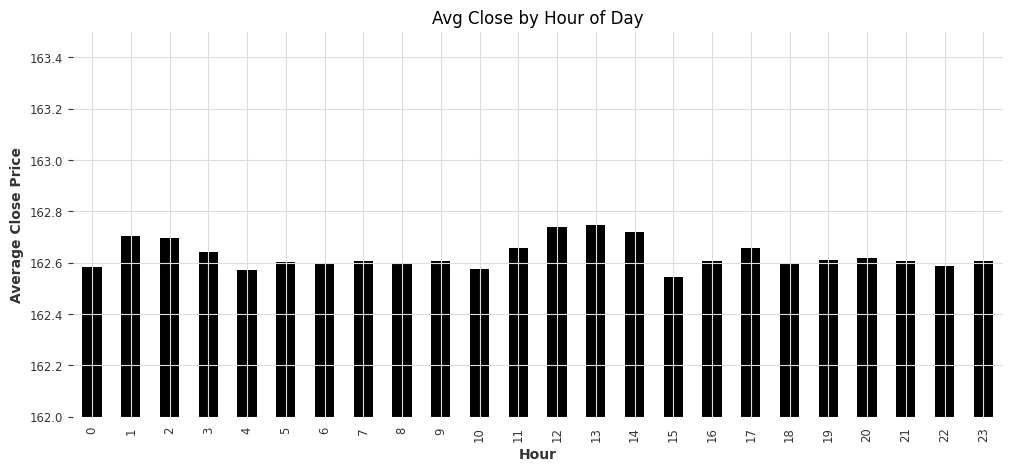

In [68]:
df_raw['Hour'] = df_raw.index.hour
ax = df_raw.groupby('Hour')['Close'].mean().plot(kind='bar', figsize=(12, 5))
ax.set_title('Avg Close by Hour of Day')
ax.set_ylabel('Average Close Price')
#ax.set_ylim(163.1, 163.50)  # adjust this based on data range
ax.set_ylim(162, 163.50)

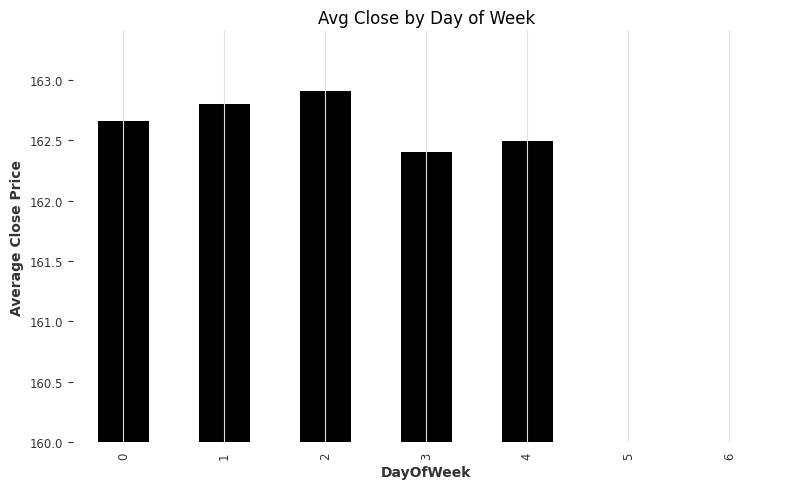

In [69]:
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# Create the 'DayOfWeek' column from the index (which is Datetime)
df_raw['DayOfWeek'] = df_raw.index.dayofweek # Monday=0, Sunday=6

avg_close = df_raw.groupby('DayOfWeek')['Close'].mean()

ax = avg_close.plot(
    kind='bar',
    figsize=(8, 5),
    title='Avg Close by Day of Week'
)
#ax.set_xticklabels(day_labels, rotation=0)
ax.set_ylabel('Average Close Price')
#ax.set_ylim(163, 163.4)  # adjust based on Close price range
ax.set_ylim(160, 163.4)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

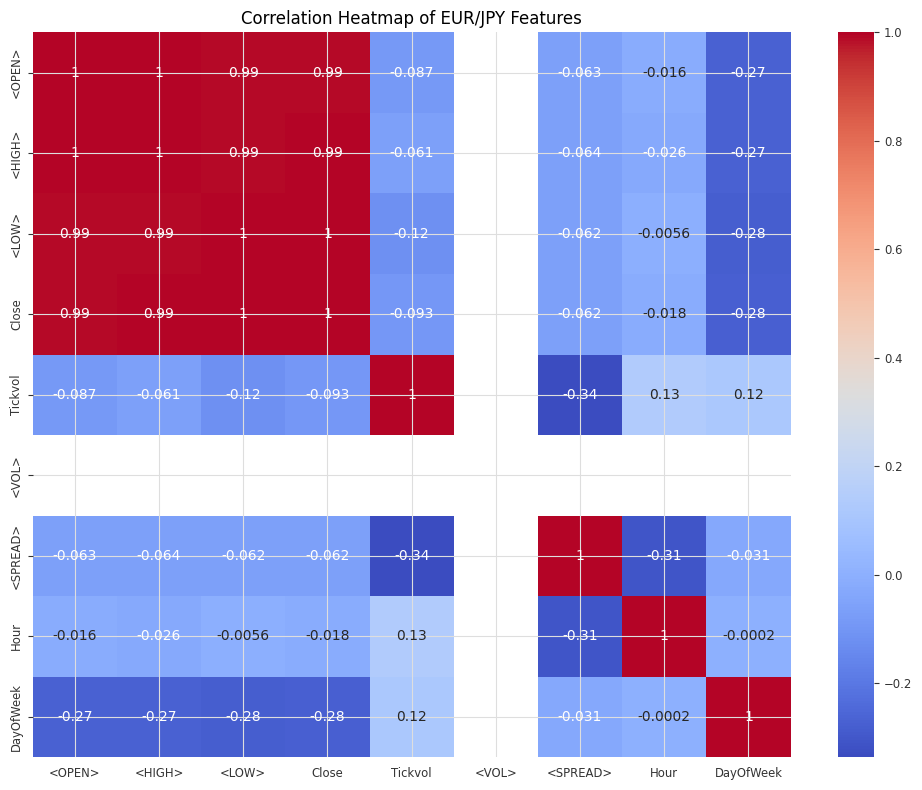

In [70]:
import seaborn as sns
plt.figure(figsize=(10, 8))  # Width=10, Height=8 (adjust as needed)
sns.heatmap(df_raw.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of EUR/JPY Features')
plt.tight_layout()
plt.show()

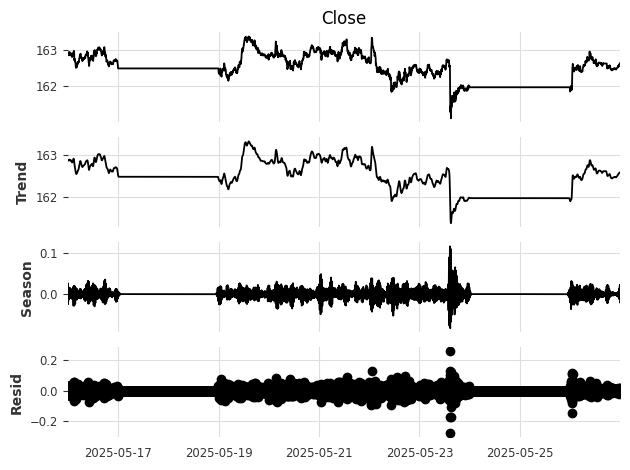

In [71]:
from statsmodels.tsa.seasonal import STL
#stl = STL(df['Close'], period=288)
stl = STL(df['Close'], period=5)
res = stl.fit()
res.plot()
plt.show()

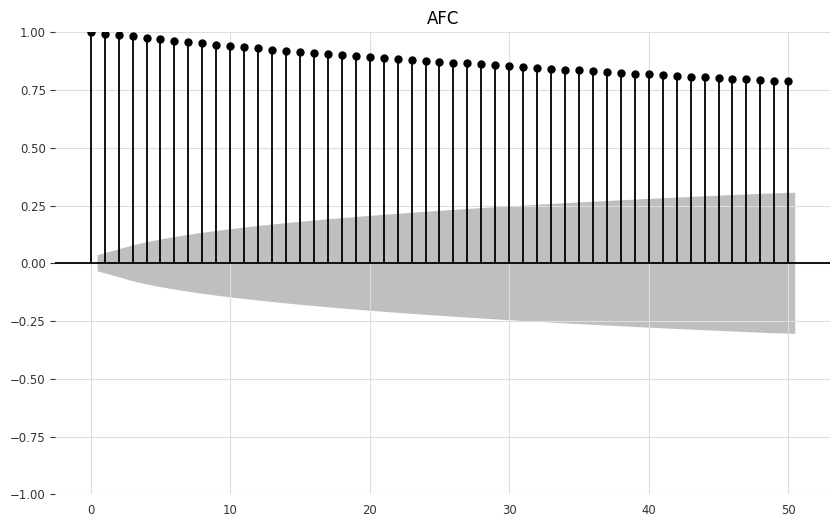

In [72]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['Close'], lags = 50, ax = ax)
plt.title('AFC')
plt.show()

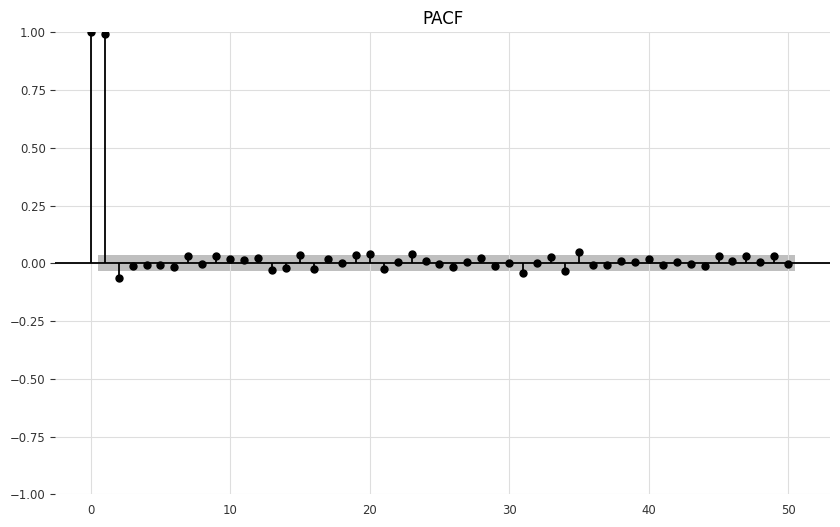

In [73]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['Close'], lags = 50, ax = ax)
plt.title('PACF')
plt.show()

# LSTM Preparation

In [74]:
# prepare the time series object
series = TimeSeries.from_series(df['Close'])
covariates = TimeSeries.from_dataframe(df, value_cols=['Tickvol', '<SPREAD>'])

In [75]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Weekday one-hot (Monday–Sunday)
weekday_series = datetime_attribute_timeseries(series, attribute="weekday", one_hot=True)

# Hour one-hot (0–23)
hour_series = datetime_attribute_timeseries(series, attribute="hour", one_hot=True)

# Combine them
past_covariates = weekday_series.stack(hour_series)


In [76]:
# Scaling
scaler1 = Scaler()
scaler2 = Scaler()

In [77]:
# Apply scaling for the timeseries
y_transformed = scaler1.fit_transform(series)

In [78]:
# Scale the covariates
final_covariates = past_covariates.stack(covariates)
covariates_transformed = scaler2.fit_transform(final_covariates)

In [79]:
covariates_transformed

<TimeSeries (DataArray) (Datetime: 3171, component: 33, sample: 1)> Size: 837kB
array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.        ],
        [0.16709957],
        [0.09345794]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.        ],
        [0.12813853],
        [0.09345794]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
...
        ...,
        [1.        ],
        [0.08051948],
        [0.09345794]],

       [[1.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.        ],
        [0.03809524],
        [0.09345794]],

       [[1.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.        ],
        [0.13073593],
        [0.09345794]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 25kB 2025-05-15T23:45:00 ... 2025-05...
  * component  (component) object 264B 'weekday_0' 'weekday_1' ... '<SPREAD>'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# LSTM Model

In [80]:
# build lstm model
forecasting_horizon = 31
input_chunk_length = 46
training_length = forecasting_horizon + input_chunk_length

In [81]:
# Initialize the LSTM model with specified parameters
model = RNNModel(model = "LSTM",                        # Specify LSTM as the type of RNN model
                 hidden_dim = 20,                       # Set the number of hidden units in LSTM layers
                 n_rnn_layers = 2,                      # Define the number of RNN layers
                 dropout = 0.1,                         # Set dropout rate for regularization
                 n_epochs = 10,                         # Define the number of training epochs
                 optimizer_kwargs = {"lr": 0.003},      # Specify learning rate for the optimizer
                 random_state = 1502,                   # Set random seed for reproducibility
                 training_length = training_length,     # Set the length of the training data
                 input_chunk_length = input_chunk_length,     # Set the length of input chunks for the model
                 pl_trainer_kwargs = {"accelerator": "gpu",
                                      "devices": [0]}
                 )

# Fit the model with transformed target data and covariates
model.fit(y_transformed, future_covariates = covariates_transformed)


Training: |          | 0/? [00:00<?, ?it/s]

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=77, n_epochs=10, optimizer_kwargs={'lr': 0.003}, random_state=1502, input_chunk_length=46, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

# Cross-Validation

In [82]:
# Perform cross-validation with a rolling forecasting window
cv = model.historical_forecasts(series = y_transformed,
                                future_covariates = covariates_transformed,
                                start = df.shape[0] - 180,
                                forecast_horizon = forecasting_horizon,
                                stride = 16,
                                retrain = True,
                                last_points_only = False)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [83]:
# Initialize a list to store RMSE values for cross-validation
rmse_cv = []

# Iterate over each forecast result from cross-validation
for i in range(len(cv)):

  ts = scaler1.inverse_transform(cv[i])
  predictions = pd.Series(ts.values().flatten(), index=ts.time_index)

  # Determine the range of dates for actual values
  start = predictions.index.min()
  end = predictions.index.max()

  # Extract the actual values from the original dataset
  actuals = df.Close[start:end,]

  # Calculate the RMSE for the current cross-validation fold
  error_cv = np.sqrt(mean_squared_error(actuals, predictions))
  # Append the RMSE to the list
  rmse_cv.append(error_cv)

# Print the mean RMSE across all cross-validation folds
print(np.mean(rmse_cv))

0.24551878698754015


# Parameter Tuning

In [84]:
# Define the parameter grid for tuning
param_grid = {'n_rnn_layers': [1, 2],                 # Number of RNN layers to test
              'hidden_dim': [10, 20],                 # Number of hidden units in the LSTM layers
              'dropout': [0.1, 0.2],                  # Dropout rates to test
              'n_epochs': [5, 10],                    # Number of epochs for training
              'lr': [0.003],                          # Learning rates to test
              'training_length': [77],                # Training length to use
              'input_chunk_length': [46]}             # Length of input chunks to use

# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)

# Get the total number of parameter combinations
len(list(grid))

16

In [85]:
# Initialize a list to store RMSE values for each parameter combination
rmse = []

# Iterate over each parameter combination in the grid
for params in grid:
  # Build the LSTM model with the current set of parameters
  model = RNNModel(model = "LSTM",
                  hidden_dim = params['hidden_dim'],                   # Set the number of hidden units
                  n_rnn_layers = params['n_rnn_layers'],               # Set the number of RNN layers
                  dropout = params['dropout'],                         # Set the dropout rate
                  n_epochs = params['n_epochs'],                       # Set the number of training epochs
                  optimizer_kwargs = {"lr": params['lr']},             # Set the learning rate
                  random_state = 1502,                                 # Set random seed for reproducibility
                  training_length = params['training_length'],         # Set the training length
                  input_chunk_length = params['input_chunk_length'],   # Set the length of input chunks
                  #pl_trainer_kwargs = {"accelerator": "cpu"}           # Specify training on CPU
                  pl_trainer_kwargs = {"accelerator": "gpu",
                                       "devices": [0],
                                       "enable_progress_bar": False,
                                       "logger": False,
                                       "enable_model_summary": False}
                  )

  # Fit the model with the transformed data and covariates
  model.fit(y_transformed, future_covariates = covariates_transformed)

  # Perform cross-validation with a rolling forecasting window
  cv = model.historical_forecasts(series = y_transformed,
                                    future_covariates = covariates_transformed,
                                    start = df.shape[0] - 180,          # Set the start point for the forecasting window
                                    forecast_horizon = forecasting_horizon, # Define the forecast horizon
                                    stride = 16,                       # Set the stride for rolling window
                                    retrain = True,                    # Specify to retrain the model at each step
                                    last_points_only = False)          # Specify whether to use only the last points

  # Initialize a list to store RMSE values for cross-validation
  rmse_cv = []

  # Iterate over each forecast result from cross-validation
  for i in range(len(cv)):
    # Convert forecasted values back to the original scale
    ts = scaler1.inverse_transform(cv[i])
    predictions = pd.Series(ts.values().flatten(), index=ts.time_index)

    # Determine the range of dates for actual values
    start = predictions.index.min()
    end = predictions.index.max()

    # Extract the actual values from the original dataset
    actuals = df.Close[start:end]

    # Calculate the RMSE for the current cross-validation fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)


  # Calculate and store the mean RMSE for the current parameter combination
  error = np.mean(rmse_cv)
  rmse.append(error)

In [86]:
# Create a DataFrame and add the RMSE values
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.1,10,46,0.003,5,1,77,0.211596
1,0.1,10,46,0.003,5,2,77,0.244910
2,0.1,10,46,0.003,10,1,77,0.268652
3,0.1,10,46,0.003,10,2,77,0.287417
4,0.1,20,46,0.003,5,1,77,0.192364
5,0.1,20,46,0.003,5,2,77,0.257303
6,0.1,20,46,0.003,10,1,77,0.206435
7,0.1,20,46,0.003,10,2,77,0.245519
8,0.2,10,46,0.003,5,1,77,0.211596
9,0.2,10,46,0.003,5,2,77,0.232449


In [87]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("round1.csv")

# Parameter Tuning 2

In [88]:
# Load the best parameters from the CSV file
params_round1 = pd.read_csv("round1.csv", index_col = 0)
params_round1

,4
dropout,0.100000
hidden_dim,20.000000
input_chunk_length,46.000000
lr,0.003000
n_epochs,5.000000
n_rnn_layers,1.000000
training_length,77.000000
rmse,0.192364


In [89]:
# Isolate and convert the three parameters from the best parameter set
n_rnn_layers = int(params_round1.loc["n_rnn_layers"].iloc[0])  # Extract and convert the number of RNN layers
hidden_dim = int(params_round1.loc["hidden_dim"].iloc[0])      # Extract and convert the number of hidden units
dropout = params_round1.loc["dropout"].iloc[0]                 # Extract the dropout rate
dropout  # Display the dropout rate

np.float64(0.1)

In [90]:
# Define the parameter grid for tuning
param_grid = {'n_rnn_layers': [n_rnn_layers],
              'hidden_dim': [hidden_dim],
              'dropout': [dropout],
              'n_epochs': [5, 10],
              'lr': [0.003, 0.01],
              'training_length': [60, 77],
              'input_chunk_length': [35, 46]}

# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)
# Get the total number of parameter combinations
len(list(grid))

16

In [91]:
# Initialize a list to store RMSE values for each parameter combination
rmse = []

# Iterate over each parameter combination in the grid
for params in grid:
  # Build the LSTM model with the current set of parameters
  model = RNNModel(model = "LSTM",
                  hidden_dim = params['hidden_dim'],                   # Set the number of hidden units
                  n_rnn_layers = params['n_rnn_layers'],               # Set the number of RNN layers
                  dropout = params['dropout'],                         # Set the dropout rate
                  n_epochs = params['n_epochs'],                       # Set the number of training epochs
                  optimizer_kwargs = {"lr": params['lr']},             # Set the learning rate
                  random_state = 1502,                                 # Set random seed for reproducibility
                  training_length = params['training_length'],         # Set the training length
                  input_chunk_length = params['input_chunk_length'],   # Set the length of input chunks
                  #pl_trainer_kwargs = {"accelerator": "cpu"}           # Specify training on CPU
                  pl_trainer_kwargs = {"accelerator": "gpu",
                                       "devices": [0],
                                       "enable_progress_bar": False,
                                       "logger": False,
                                       "enable_model_summary": False}
                  )

  # Fit the model with the transformed data and covariates
  model.fit(y_transformed, future_covariates = covariates_transformed)

  # Perform cross-validation with a rolling forecasting window
  cv = model.historical_forecasts(series = y_transformed,
                                    future_covariates = covariates_transformed,
                                    start = df.shape[0] - 180,          # Set the start point for the forecasting window
                                    forecast_horizon = forecasting_horizon, # Define the forecast horizon
                                    stride = 16,                       # Set the stride for rolling window
                                    retrain = True,                    # Specify to retrain the model at each step
                                    last_points_only = False)          # Specify whether to use only the last points

  # Initialize a list to store RMSE values for cross-validation
  rmse_cv = []

  # Iterate over each forecast result from cross-validation
  for i in range(len(cv)):
    # Convert forecasted values back to the original scale
    ts = scaler1.inverse_transform(cv[i])
    predictions = pd.Series(ts.values().flatten(), index=ts.time_index)

    # Determine the range of dates for actual values
    start = predictions.index.min()
    end = predictions.index.max()

    # Extract the actual values from the original dataset
    actuals = df.Close[start:end]

    # Calculate the RMSE for the current cross-validation fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)


  # Calculate and store the mean RMSE for the current parameter combination
  error = np.mean(rmse_cv)
  rmse.append(error)

In [92]:
# Retrieve the best params and put in in a dataframe
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.1,20,35,0.003,5,1,60,0.185588
1,0.1,20,35,0.003,5,1,77,0.192363
2,0.1,20,35,0.003,10,1,60,0.198164
3,0.1,20,35,0.003,10,1,77,0.206435
4,0.1,20,35,0.010,5,1,60,0.240626
5,0.1,20,35,0.010,5,1,77,0.226760
6,0.1,20,35,0.010,10,1,60,0.246908
7,0.1,20,35,0.010,10,1,77,0.226842
8,0.1,20,46,0.003,5,1,60,0.185588
9,0.1,20,46,0.003,5,1,77,0.192364


In [93]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("round2.csv")

# Predict The Future

In [94]:
# Load the best parameters from the CSV file
params_round2 = pd.read_csv("round2.csv", index_col = 0)
params_round2

,0
dropout,0.100000
hidden_dim,20.000000
input_chunk_length,35.000000
lr,0.003000
n_epochs,5.000000
n_rnn_layers,1.000000
training_length,60.000000
rmse,0.185588


In [95]:
# Load Training Data (EURJPY5.csv) & use tail(2000)
df_train = pd.read_csv("EURJPY5.csv")
df_train = df_train.rename(columns={'<DATE>': 'Date', '<TIME>': 'Time', '<CLOSE>': 'Close', '<TICKVOL>': 'Tickvol'})
df_train['Datetime'] = pd.to_datetime(df_train['Date'] + ' ' + df_train['Time'])
df_train = df_train.set_index('Datetime').asfreq('5min').fillna(method='ffill')
df_train = df_train[['Close']].tail(2000)

In [96]:
# Load Forecast Data (Future.csv head(500))
df_future = pd.read_csv("Future.csv")
df_future = df_future.rename(columns={'<DATE>': 'Date', '<TIME>': 'Time', '<CLOSE>': 'Close', '<TICKVOL>': 'Tickvol'})
df_future['Datetime'] = pd.to_datetime(df_future['Date'] + ' ' + df_future['Time'])
df_future = df_future.set_index('Datetime')
df_future = df_future.drop(columns=['Date', 'Time'])
df_future = df_future.asfreq('5min').fillna(method='ffill')
df_future = df_future.head(500)

In [97]:
# Create TimeSeries
series = TimeSeries.from_dataframe(df_train[['Close']])
future_series = TimeSeries.from_dataframe(df_future[['Close']])

# Combine for covariates generation
combined_df = pd.concat([df_train[['Close']], df_future[['Close']]])
combined_df = combined_df[~combined_df.index.duplicated(keep='first')].asfreq('5min').fillna(method='ffill')
combined_series = TimeSeries.from_dataframe(combined_df)


In [98]:
# Future Covariates (weekday + hour)
weekday = datetime_attribute_timeseries(combined_series, attribute="weekday", one_hot=True)
hour = datetime_attribute_timeseries(combined_series, attribute="hour", one_hot=True)
combined_covariates = weekday.stack(hour)


In [99]:
#  Scale
scaler_y = Scaler()
series_scaled = scaler_y.fit_transform(series)

scaler_cov = Scaler()
combined_cov_scaled = scaler_cov.fit_transform(combined_covariates)

cov_train = combined_cov_scaled.slice_intersect(series_scaled)
cov_pred = combined_cov_scaled.drop_before(series_scaled.end_time() + series_scaled.freq)


In [100]:
# Padding if needed
input_chunk_length = int(params_round2.loc["input_chunk_length"].iloc[0])
required_start = series_scaled.end_time() + series_scaled.freq - series_scaled.freq * input_chunk_length

if cov_pred.start_time() > required_start:
    pad_range = pd.date_range(start=required_start,
                              end=cov_pred.start_time() - series_scaled.freq,
                              freq=series_scaled.freq)
    pad_values = [cov_pred.values()[0]] * len(pad_range)
    pad_df = pd.DataFrame(pad_values, index=pad_range)
    pad_ts = TimeSeries.from_dataframe(pad_df)
    cov_pred = pad_ts.append(cov_pred)


In [101]:
# Init & Train Model from Best Parameters
model = RNNModel(
    model="LSTM",
    input_chunk_length=input_chunk_length,
    training_length=int(params_round2.loc["training_length"].iloc[0]),
    n_epochs=int(params_round2.loc["n_epochs"].iloc[0]),
    dropout=params_round2.loc["dropout"].iloc[0],
    hidden_dim=int(params_round2.loc["hidden_dim"].iloc[0]),
    n_rnn_layers=int(params_round2.loc["n_rnn_layers"].iloc[0]),
    optimizer_kwargs={'lr': params_round2.loc["lr"].iloc[0]},
    random_state=42,
    batch_size=32,
    pl_trainer_kwargs={"accelerator": "cpu"},
)

model.fit(series_scaled, future_covariates=cov_train, verbose=True)


Training: |          | 0/? [00:00<?, ?it/s]

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.1, training_length=60, input_chunk_length=35, n_epochs=5, optimizer_kwargs={'lr': np.float64(0.003)}, random_state=42, batch_size=32, pl_trainer_kwargs={'accelerator': 'cpu'})

In [102]:
# Lakukan prediksi menggunakan model yang telah dilatih
forecast_scaled = model.predict(
    n=len(df_future),  # jumlah langkah prediksi (sama dengan panjang df_future)
    series=series_scaled,
    future_covariates=cov_pred
)


Predicting: |          | 0/? [00:00<?, ?it/s]

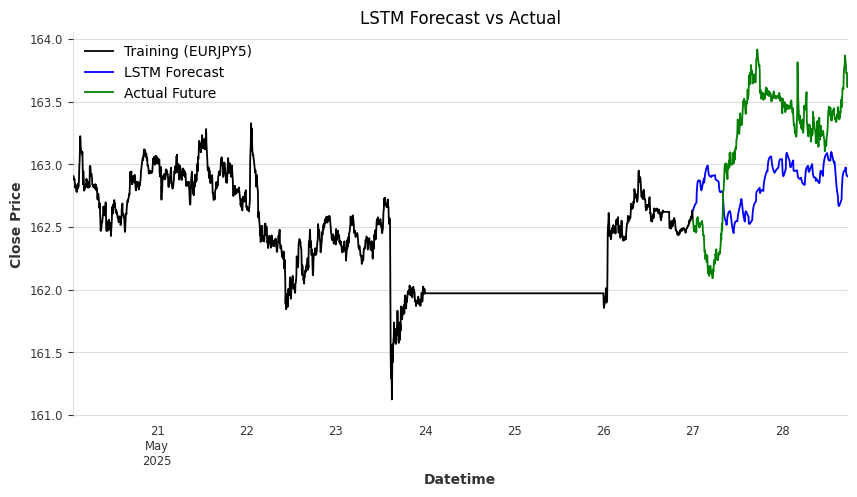

In [103]:
# Inverse
forecast = scaler_y.inverse_transform(forecast_scaled)
forecast = pd.Series(forecast.values().flatten(), index=forecast.time_index).rename("LSTM")

# actual data
actual = df_future['Close']
actual.name = "Actual"
actual = actual[actual.index.isin(forecast.index)]

# conversion
training_series = pd.Series(series.values().flatten(), index=series.time_index).rename("Training (EURJPY5)")

#  Plot
plt.figure(figsize=(10, 5))

training_series.plot(label="Training (EURJPY5)", color='black')
forecast.plot(label="LSTM Forecast", color='blue')
actual.plot(label="Actual Future", color='green')

plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Datetime")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


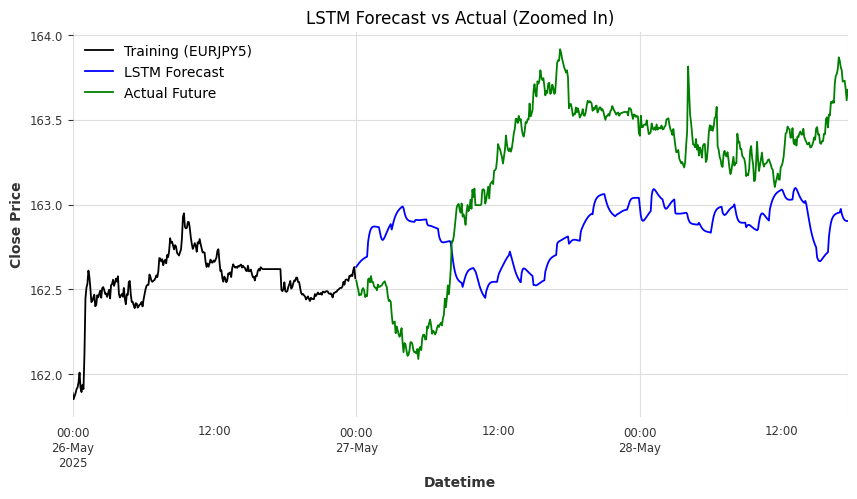

In [104]:
#  Inverse
forecast = scaler_y.inverse_transform(forecast_scaled)
forecast = pd.Series(forecast.values().flatten(), index=forecast.time_index).rename("LSTM")

# Actual data
actual = df_future['Close']
actual.name = "Actual"
actual = actual[actual.index.isin(forecast.index)]

training_series = pd.Series(series.values().flatten(), index=series.time_index).rename("Training (EURJPY5)")

# Time Filter
start = "2025-05-26"
end = "2025-05-29"

training_zoom = training_series[start:end]
forecast_zoom = forecast[start:end]
actual_zoom = actual[start:end]

# Plot zoomed-in view
plt.figure(figsize=(10, 5))

training_zoom.plot(label="Training (EURJPY5)", color='black')
forecast_zoom.plot(label="LSTM Forecast", color='blue')
actual_zoom.plot(label="Actual Future", color='green')

plt.legend()
plt.title("LSTM Forecast vs Actual (Zoomed In)")
plt.xlabel("Datetime")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [105]:
# Make sure the forecast and actual have the same index
forecast_aligned = forecast[forecast.index.isin(actual.index)]
actual_aligned = actual[actual.index.isin(forecast.index)]

# RMSE
rmse = np.sqrt(mean_squared_error(actual_aligned, forecast_aligned))
print(f"RMSE: {rmse:.4f}")

# MAE
mae = mean_absolute_error(actual_aligned, forecast_aligned)
print(f"MAE: {mae:.4f}")

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

mape = mean_absolute_percentage_error(actual_aligned, forecast_aligned)
print(f"MAPE: {mape:.2f}%")

RMSE: 0.6007
MAE: 0.5501
MAPE: 0.34%
